In [1]:
import pandas as pd
import pickle
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import pystan
import random
from sklearn.neighbors import KernelDensity
from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal, gaussian_kde, entropy
from fastkde import fastKDE
from entropy_estimators import continuous
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns

# Helper functions    

In [26]:
def KLdivergence(x, y):
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)

    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
    thresh = 1e-4
    r = xtree.query(x, k=1000, eps=.01, p=2)[0]
    r = r[np.arange(r.shape[0]), np.argmax(r > thresh, axis=1)] 
    s = ytree.query(x, k=1000, eps=.01, p=2)[0]
    s = s[np.arange(s.shape[0]), np.argmax(s > thresh, axis=1)]

    # throw out samples that are all 0
    s = s[r != 0]
    r = r[r != 0] 
    
    if math.isinf(-np.log(r/s).sum() * d / n + np.log(m / (n - 1.))):
        a = 0;

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

def surprisal(dist, sample):
    kde = gaussian_kde(dist)
    prob = kde.evaluate(sample)
    return -np.log(prob)
  

Build model

In [27]:
# whether to recompile the stan program
DO_COMPILE = False

# simple noise or prior on noise
SIMPLE_NOISE = True

# stan program path
if SIMPLE_NOISE:
    stan_path = 'multi_feature_simple_noise.stan'
    pkl_file = 'model_simple_noise.pkl'
else:
    stan_path = 'multi_feature.stan'
    pkl_file = 'model.pkl'


def build_model(path, pkl_file=None, do_compile=True):
    if do_compile:
        sm = pystan.StanModel(file=path)
        if pkl_file is not None:
            with open(pkl_file, 'wb') as f:
                pickle.dump(sm, f)

    # if the program hasn't been complied, check that the file already exists
    else: 
        if os.path.isfile(pkl_file):
            sm = pickle.load(open(pkl_file, 'rb'))
        else:
            raise FileNotFoundError
    return sm


sm = build_model(path = stan_path, pkl_file='model_simple_noise.pkl', do_compile=DO_COMPILE)

Model parameters

In [28]:
# mu
mu_mean = 0
mu_sd = 0.5

# sd
sigma_alpha = 2
sigma_beta = 2

# noise SD prior
epsilon_alpha = 1
epsilon_beta = 1

# for simple noise 
noise = 0.1

# environmental EIG
env_info = 0.02

Create data

In [29]:

# number of stimuli
sequence_length = 6

# number of features 
num_features = 1

# number of samples (max)
num_samples = 3000

# allocation of samples to exemplars
exemplar_idx = np.repeat(np.arange(1, sequence_length+1), num_samples/sequence_length)

# background / deviant mean values
background = np.repeat(1, num_features)
deviant = np.repeat(3, num_features)

# perceptual noise
sig = np.identity(num_features) * 0.1;

# deviant position
deviant_pos = 6

# stimulus means
exemplar_means = np.tile(background, (sequence_length, 1))
exemplar_means[deviant_pos-1] = deviant

Simulation parameters

In [43]:
# number of iterations and warmup per model run
num_iter = 10000
num_warmup = 5000

# number of total model runs
num_model_runs = 3

# how much to thin posteriors
thinning_factor = 10


Initialize flags, variables, iterators 

In [44]:
# Flags 
sample = True
policy = 'kl' # 'kl', 'surprisal', 'entropy' or 'eig'

# Variables
model_LT = np.zeros((num_model_runs, sequence_length))

# prior parameters
prior_mu = np.random.multivariate_normal(np.repeat(mu_mean, num_features), np.identity(num_features)*mu_sd, num_iter-num_warmup)

prior_sigma = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_features):
    prior_sigma[:,i] = np.random.gamma(sigma_alpha, sigma_beta, num_iter-num_warmup)

prior_z_rep = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_iter-num_warmup):
    prior_z_rep[i,:] = np.random.multivariate_normal(prior_mu[i,:], np.identity(num_features)*prior_sigma[i,:])

prior = np.hstack((prior_mu, prior_sigma))

data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, 
"epsilon_alpha": epsilon_alpha, "epsilon_beta": epsilon_beta, "noise": noise, "F": num_features}

stim_info = np.empty((num_model_runs, num_samples))
stim_info[:] = np.nan

# Action loop


Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.086635 seconds (Warm-up)
               0.079497 seconds (Sampling)
               0.166132 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.103848 seconds (Warm-up)
               0.089157 seconds (Sampling)
               0.193005 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.100093 seconds (Warm-up)
               0.079702 seconds (Sampling)
               0.179795 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.194792 seconds (Warm-up)
               0.139037 seconds (Sampling)
               0.333829 seconds (Total)


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iter


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.147806 seconds (Warm-up)
               0.148355 seconds (Sampling)
               0.296161 seconds (Total)


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iterati


Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.151926 seconds (Warm-up)
               0.156108 seconds (Sampling)
               0.308034 seconds (Total)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Ite

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.194917 seconds (Warm-up)
               0.215401 seconds (Sampling)
               0.410318 seconds (Total)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.21164 seconds (Warm-up)
               0.222904 seconds (Sampling)
               0.434544 seconds (Total)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
It


Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.107051 seconds (Warm-up)
               0.196529 seconds (Sampling)
               0.30358 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.101881 seconds (Warm-up)
               0.090512 seconds (Sampling)
               0.192393 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.114149 seconds (Warm-up)
               0.170667 seconds (Sampling)
               0.284816 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.111095 seconds (Warm-up)
               0.082521 seconds (Sampling)
               0.193616 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.11914 seconds (Warm-up)
               0.096882 seconds (Sampling)
               0.216022 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.119176 seconds (Warm-up)
               0.127624 seconds (Sampling)
               0.2468 seconds (Total)




Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.120656 seconds (Warm-up)
               0.124614 seconds (Sampling)
               0.24527 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.126412 seconds (Warm-up)
               0.098346 seconds (Sampling)
               0.224758 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.122356 seconds (Warm-up)
               0.157633 seconds (Sampling)
               0.279989 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.193182 seconds (Warm-up)
               0.184157 seconds (Sampling)
               0.377339 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.182162 seconds (Warm-up)
               0.198679 seconds (Sampling)
               0.380841 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.191261 seconds (Warm-up)
               0.255349 seconds (Sampling)
               0.44661 seconds (Total)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
It


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.202287 seconds (Warm-up)
               0.234068 seconds (Sampling)
               0.436355 seconds (Total)


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iter

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.234562 seconds (Warm-up)
               0.19227 seconds (Sampling)
               0.426832 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.20913 seconds (Warm-up)
               0.233666 seconds (Sampling)
               0.442796 seconds (Total)


Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Itera

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.262997 seconds (Warm-up)
               0.147513 seconds (Sampling)
               0.41051 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.107749 seconds (Warm-up)
               0.121601 seconds (Sampling)
               0.22935 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.112533 seconds (Warm-up)
               0.125558 seconds (Sampling)
               0.238091 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.117955 seconds (Warm-up)
               0.092491 seconds (Sampling)
               0.210446 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.110237 seconds (Warm-up)
               0.075972 seconds (Sampling)
               0.186209 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.113692 seconds (Warm-up)
               0.106101 seconds (Sampling)
               0.219793 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.124901 seconds (Warm-up)
               0.123942 seconds (Sampling)
               0.248843 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.158459 seconds (Warm-up)
               0.151512 seconds (Sampling)
               0.309971 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.186528 seconds (Warm-up)
               0.160531 seconds (Sampling)
               0.347059 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.255782 seconds (Warm-up)
               0.337386 seconds (Sampling)
               0.593168 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.259453 seconds (Warm-up)
               0.223586 seconds (Sampling)
               0.483039 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.259584 seconds (Warm-up)
               0.246851 seconds (Sampling)
               0.506435 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.236574 seconds (Warm-up)
               0.330759 seconds (Sampling)
               0.567333 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.230495 seconds (Warm-up)
               0.297304 seconds (Sampling)
               0.527799 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.249447 seconds (Warm-up)
               0.232647 seconds (Sampling)
               0.482094 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.265731 seconds (Warm-up)
               0.228356 seconds (Sampling)
               0.494087 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.223811 seconds (Warm-up)
               0.198822 seconds (Sampling)
               0.422633 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.243949 seconds (Warm-up)
               0.174667 seconds (Sampling)
               0.418616 seconds (Total)


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iter

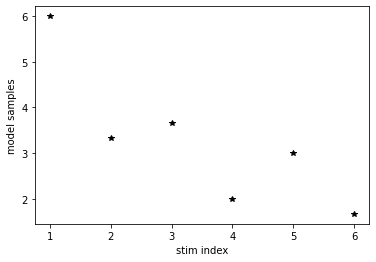

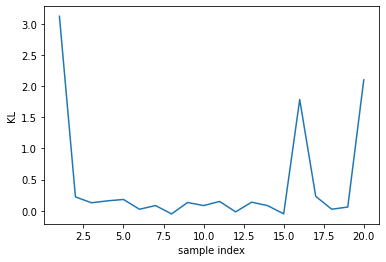

In [45]:
for run in np.arange(0, num_model_runs):

    # generate the data
    sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
    sim_data = np.asmatrix(sim_data)

    # Iterators
    samples_from_current_stim = 1
    total_samples = 1
    exemplar_num = 1

    # initialize data
    sample_data = np.empty((num_samples,num_features))
    sample_data[:] = np.nan

    exemplar_labels = np.empty((num_samples,))
    exemplar_labels[:] = np.nan

    while sample or samples_from_current_stim > 1:
        
        # sample number
        data["M"] = total_samples

        # exemplar number 
        data["K"] = exemplar_num

        # add sim data
        sample_data[total_samples-1] = sim_data[exemplar_idx == exemplar_num][samples_from_current_stim-1]
        data["z"] = np.transpose(sample_data[0:total_samples,:])

        # add exemplar for each id
        exemplar_labels[total_samples-1] = int(exemplar_num)
        data["exemplar_idx"] = [int(x) for x in exemplar_labels[~np.isnan(exemplar_labels)]]

        # get posterior samples
        fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95));
        
        
        posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
                               fit['sigma'][0:len(fit['mu']):thinning_factor]))
        
        if policy is 'kl':

            if total_samples > 20:
                break;
                a = 0;

            # KL divergence between prior and posterior
            stim_info[run, total_samples-1] = KLdivergence(prior, posterior)

        elif policy is 'entropy':
            # reduction of entropy
            stim_info[run,total_samples-1] = entropy(prior) - entropy(posterior)

        elif policy is 'surprisal':

            # surprisal of current observation given prior
            stim_info[run, total_samples-1] = surprisal(prior[:,2], sample_data[total_samples-1])

        elif policy is 'EIG':
            stim_info[run,total_samples-1] = EIG(posterior)

        # decision rule
        if stim_info[run,total_samples-1] < env_info:
            model_LT[run, exemplar_num-1] = samples_from_current_stim

            # reset/increment counters
            samples_from_current_stim = 1
            exemplar_num += 1

            if exemplar_num > sequence_length:
                sample = False

        else:
            samples_from_current_stim += 1 

        if policy is 'kl' or policy is 'surprisal' or policy is 'entropy':
            prior = posterior
        
        total_samples += 1

    # start sampling for next model run
    sample = True


plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*')

plt.xlabel("stim index")
plt.ylabel("model samples")
plt.title("")
plt.show()


plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze())

plt.xlabel("sample index")
plt.ylabel("KL")
plt.title("")
plt.show()

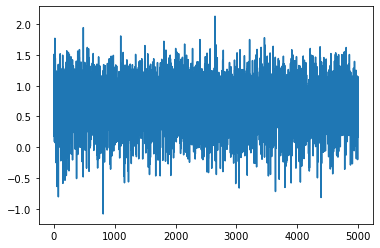

In [46]:
plt.plot(np.arange(0, len(fit['mu'])), fit['mu'])
plt.show()

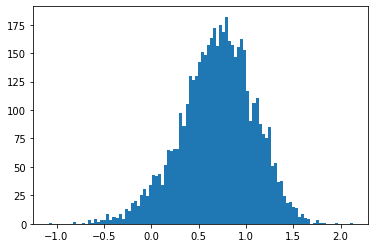

In [47]:
plt.hist(fit['mu'], bins = 100);

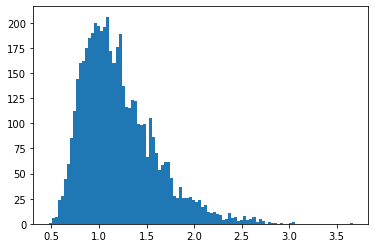

In [48]:
plt.hist(fit['sigma'], bins = 100);

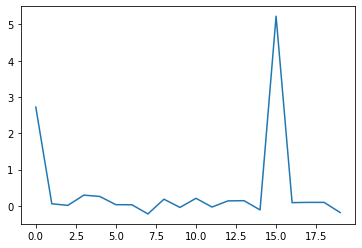

In [59]:
plt.plot(np.arange(0, stim_info.shape[1]), stim_info[0,:])
plt.show()